In [53]:
import torch
import FinanceDataReader as fdr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [54]:
df = fdr.DataReader('005930','2020-01-01')
df = df.drop('Change',axis= 1)
df

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,55500,56000,55000,55200,12993228
2020-01-03,56000,56600,54900,55500,15422255
2020-01-06,54900,55600,54600,55500,10278951
2020-01-07,55700,56400,55600,55800,10009778
2020-01-08,56200,57400,55900,56800,23501171
...,...,...,...,...,...
2025-03-25,60900,61100,59500,59800,17259455
2025-03-26,59800,61400,59700,61400,16431645
2025-03-27,60900,62000,60800,61800,20389790


<Axes: xlabel='Date'>

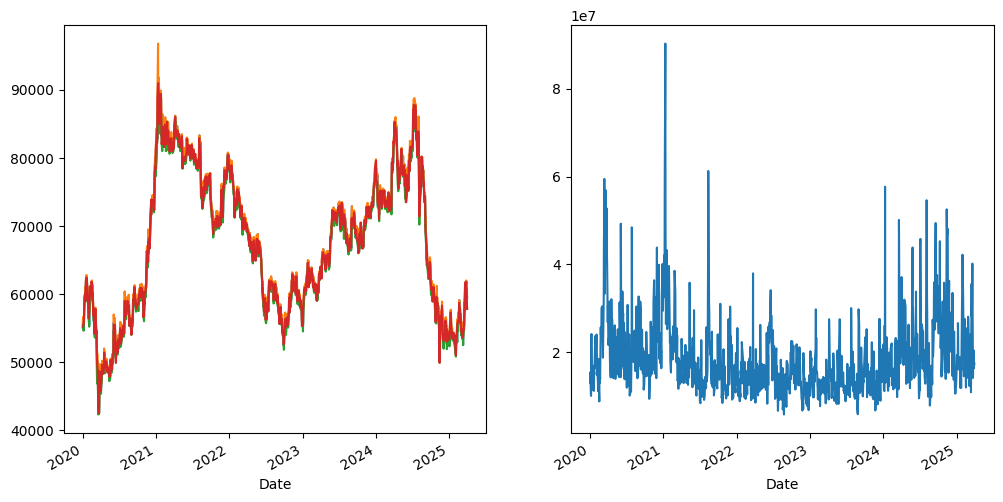

In [55]:
f,a = plt.subplots(1,2,figsize = (12,6))
df['Open'].plot(ax = a[0])
df['High'].plot(ax = a[0])
df['Low'].plot(ax = a[0])
df['Close'].plot(ax = a[0])
df['Volume'].plot(ax = a[1])

In [56]:
train_df = df.iloc[:int(0.7 * len(df))]
valid_df = df.iloc[int(0.7 * len(df)):int(0.8 * len(df))]
test_df = df.iloc[int(0.8 * len(df)):]

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)


(902, 5)
(129, 5)
(258, 5)


In [57]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()
# train_df[['Open','High','Low','Volume','Close']] = scaler_x.fit_transform(train_df[['Open','High','Low','Volume','Close']])
# valid_df[['Open','High','Low','Volume','Close']] = scaler_x.transform(valid_df[['Open','High','Low','Volume','Close']])
# test_df[['Open','High','Low','Volume','Close']] = scaler_x.transform(test_df[['Open','High','Low','Volume','Close']])
train_df[['Open','High','Low','Volume']] = scaler_x.fit_transform(train_df[['Open','High','Low','Volume']])
valid_df[['Open','High','Low','Volume']] = scaler_x.transform(valid_df[['Open','High','Low','Volume']])
test_df[['Open','High','Low','Volume']] = scaler_x.transform(test_df[['Open','High','Low','Volume']])
train_df[['Close']] = scaler_y.fit_transform(train_df[['Close']])
valid_df[['Close']] = scaler_y.transform(valid_df[['Close']])
test_df[['Close']] = scaler_y.transform(test_df[['Close']])

C:\Users\yunji\AppData\Local\Temp\ipykernel_35984\1943681322.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[['Open','High','Low','Volume']] = scaler_x.fit_transform(train_df[['Open','High','Low','Volume']])
C:\Users\yunji\AppData\Local\Temp\ipykernel_35984\1943681322.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[['Open','High','Low','Volume']] = scaler_x.transform(valid_df[['Open','High','Low','Volume']])
C:\Users\yunji\AppData\Local\Temp\ipykernel_35984\1943681322.py:9: Setting

In [58]:
# 직전 n일의 Open,High,Low,Volume feature를 기반으로 다음날 close를 예측하도록 데이터 구성

def make_ndays_dataset(n,df):
    x_list,y_list = [],[]
    x = df[['Open','High','Low','Volume']]
    y = df['Close']
    for i in range(len(df) - n):
        x_list.append(x[i:i+n].values)
        y_list.append(y.iloc[i+n])

    return np.array(x_list),np.array(y_list)



In [59]:
train_x,train_y = make_ndays_dataset(5,train_df)
valid_x,valid_y = make_ndays_dataset(5,valid_df)
test_x,test_y = make_ndays_dataset(5,test_df)
print(train_x.shape , train_y.shape)
print(valid_x.shape , valid_y.shape)
print(test_x.shape , test_y.shape)



(897, 5, 4) (897,)
(124, 5, 4) (124,)
(253, 5, 4) (253,)


In [60]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class samsumg_dataset(Dataset):
    def __init__(self,x,y):
        self.data = torch.tensor(x,dtype=torch.float32)
        self.target = torch.tensor(y,dtype=torch.float32).reshape(-1,1)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index],self.target[index]

In [61]:
train_dataset = samsumg_dataset(train_x,train_y)
valid_dataset = samsumg_dataset(valid_x,valid_y)
test_dataset = samsumg_dataset(test_x,test_y)

In [62]:
train_dataset[0]

(tensor([[-1.0833, -1.0881, -1.0751, -0.5539],
         [-1.0347, -1.0300, -1.0849, -0.2605],
         [-1.1417, -1.1269, -1.1142, -0.8817],
         [-1.0639, -1.0493, -1.0166, -0.9142],
         [-1.0153, -0.9524, -0.9873,  0.7153]]),
 tensor([-0.7779]))

In [63]:
train_loader = DataLoader(train_dataset,32,False,drop_last = True)
valid_loader = DataLoader(valid_dataset,32,False,drop_last = True)
test_loader = DataLoader(test_dataset,32,False,drop_last = True)

In [64]:
from torch import nn
class myGRU(nn.Module):
    def __init__(self,input_size,hidden_size,num_layer):
        super().__init__()
        self.gru = nn.GRU(input_size,hidden_size,num_layer,batch_first=True)
        self.fc_layer = nn.Linear(hidden_size,1)

    def forward(self,x):
        o,h = self.gru(x)
        x = o[:,-1,:]
        #x = torch.sum(h,dim = 0)
        x = self.fc_layer(x)
        return x


In [69]:
model =  myGRU(4,16,1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr= 0.001)

In [70]:
from sklearn.metrics import r2_score
from tqdm import tqdm
def train_loop(model,loss_fn,optimizer,dataloader):
    losses = 0
    label = []
    prediction = []
    tbar = tqdm(dataloader)
    for x,y in tbar:
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses += loss.item()
        prediction.extend(pred.squeeze().tolist())
        label.extend(y.squeeze().tolist())
        tbar.set_description(f'{loss.item()}')
    r2 = r2_score(label,prediction)

    return losses / len(dataloader) , r2

def val_loop(model,loss_fn,dataloader):
    losses = 0
    label = []
    prediction = []

    with torch.no_grad():
        for x,y in dataloader:
            pred = model(x)
            loss = loss_fn(pred,y)
            losses += loss.item()
            prediction.extend(pred.squeeze().tolist())
            label.extend(y.squeeze().tolist())
    r2 = r2_score(label,prediction)
    print(f'valid loss {losses / len(dataloader) : .2f} r2 {r2 : .2f}')
    return losses / len(dataloader) , r2

In [71]:
train_hist = []
train_r2_hist = []
valid_hist = []
valid_r2_hist = []

In [73]:
epoch = 200
for e in range(epoch):
    print(f'{e+1} epoch')
    tl, tr = train_loop(model,loss_fn,optimizer,train_loader)
    vl, vr = val_loop(model,loss_fn,valid_loader)
    train_hist.append(tl)
    valid_hist.append(vl)
    train_r2_hist.append(tr)
    valid_r2_hist.append(vr)

1 epoch


0.008770497515797615: 100%|██████████| 28/28 [00:00<00:00, 257.58it/s]


valid loss  0.01 r2  0.84
2 epoch


0.008766790851950645: 100%|██████████| 28/28 [00:00<00:00, 251.91it/s]


valid loss  0.01 r2  0.84
3 epoch


0.008763205260038376: 100%|██████████| 28/28 [00:00<00:00, 221.15it/s] 


valid loss  0.01 r2  0.84
4 epoch


0.008759737946093082: 100%|██████████| 28/28 [00:00<00:00, 237.80it/s]


valid loss  0.01 r2  0.84
5 epoch


0.008756391704082489: 100%|██████████| 28/28 [00:00<00:00, 263.18it/s]


valid loss  0.01 r2  0.84
6 epoch


0.008753162808716297: 100%|██████████| 28/28 [00:00<00:00, 259.74it/s] 


valid loss  0.01 r2  0.84
7 epoch


0.008750049397349358: 100%|██████████| 28/28 [00:00<00:00, 231.05it/s]


valid loss  0.01 r2  0.84
8 epoch


0.008747056126594543: 100%|██████████| 28/28 [00:00<00:00, 239.95it/s]


valid loss  0.01 r2  0.84
9 epoch


0.008744178339838982: 100%|██████████| 28/28 [00:00<00:00, 231.33it/s] 


valid loss  0.01 r2  0.84
10 epoch


0.008741415105760098: 100%|██████████| 28/28 [00:00<00:00, 211.11it/s]


valid loss  0.01 r2  0.84
11 epoch


0.00873877014964819: 100%|██████████| 28/28 [00:00<00:00, 206.43it/s] 


valid loss  0.01 r2  0.84
12 epoch


0.00873623974621296: 100%|██████████| 28/28 [00:00<00:00, 219.80it/s] 


valid loss  0.01 r2  0.84
13 epoch


0.008733823895454407: 100%|██████████| 28/28 [00:00<00:00, 200.25it/s]


valid loss  0.01 r2  0.84
14 epoch


0.008731525391340256: 100%|██████████| 28/28 [00:00<00:00, 197.83it/s]


valid loss  0.01 r2  0.84
15 epoch


0.008729343302547932: 100%|██████████| 28/28 [00:00<00:00, 166.93it/s] 


valid loss  0.01 r2  0.84
16 epoch


0.008727277629077435: 100%|██████████| 28/28 [00:00<00:00, 183.77it/s] 


valid loss  0.01 r2  0.84
17 epoch


0.008725319057703018: 100%|██████████| 28/28 [00:00<00:00, 161.87it/s]


valid loss  0.01 r2  0.84
18 epoch


0.008723484352231026: 100%|██████████| 28/28 [00:00<00:00, 165.97it/s] 


valid loss  0.01 r2  0.85
19 epoch


0.008721764199435711: 100%|██████████| 28/28 [00:00<00:00, 158.73it/s]


valid loss  0.01 r2  0.85
20 epoch


0.008720154874026775: 100%|██████████| 28/28 [00:00<00:00, 139.92it/s] 


valid loss  0.01 r2  0.85
21 epoch


0.008718668483197689: 100%|██████████| 28/28 [00:00<00:00, 181.10it/s] 


valid loss  0.01 r2  0.85
22 epoch


0.008717295713722706: 100%|██████████| 28/28 [00:00<00:00, 184.37it/s]


valid loss  0.01 r2  0.85
23 epoch


0.008716042153537273: 100%|██████████| 28/28 [00:00<00:00, 181.22it/s]


valid loss  0.01 r2  0.85
24 epoch


0.008714905939996243: 100%|██████████| 28/28 [00:00<00:00, 171.00it/s] 


valid loss  0.01 r2  0.85
25 epoch


0.008713887073099613: 100%|██████████| 28/28 [00:00<00:00, 186.48it/s] 


valid loss  0.01 r2  0.85
26 epoch


0.00871298648416996: 100%|██████████| 28/28 [00:00<00:00, 180.65it/s] 


valid loss  0.01 r2  0.85
27 epoch


0.008712208829820156: 100%|██████████| 28/28 [00:00<00:00, 165.83it/s] 


valid loss  0.01 r2  0.85
28 epoch


0.008711550384759903: 100%|██████████| 28/28 [00:00<00:00, 164.69it/s] 


valid loss  0.01 r2  0.85
29 epoch


0.00871101301163435: 100%|██████████| 28/28 [00:00<00:00, 156.96it/s]  


valid loss  0.01 r2  0.85
30 epoch


0.008710597641766071: 100%|██████████| 28/28 [00:00<00:00, 181.36it/s]


valid loss  0.01 r2  0.85
31 epoch


0.008710305206477642: 100%|██████████| 28/28 [00:00<00:00, 148.56it/s] 


valid loss  0.01 r2  0.85
32 epoch


0.008710134774446487: 100%|██████████| 28/28 [00:00<00:00, 182.89it/s]


valid loss  0.01 r2  0.85
33 epoch


0.008710089139640331: 100%|██████████| 28/28 [00:00<00:00, 154.76it/s] 


valid loss  0.01 r2  0.85
34 epoch


0.008710166439414024: 100%|██████████| 28/28 [00:00<00:00, 170.05it/s]


valid loss  0.01 r2  0.85
35 epoch


0.00871036946773529: 100%|██████████| 28/28 [00:00<00:00, 172.18it/s] 


valid loss  0.01 r2  0.85
36 epoch


0.008710700087249279: 100%|██████████| 28/28 [00:00<00:00, 196.75it/s]


valid loss  0.01 r2  0.85
37 epoch


0.008711151778697968: 100%|██████████| 28/28 [00:00<00:00, 165.08it/s] 


valid loss  0.01 r2  0.85
38 epoch


0.008711734786629677: 100%|██████████| 28/28 [00:00<00:00, 140.11it/s] 


valid loss  0.01 r2  0.85
39 epoch


0.008712444454431534: 100%|██████████| 28/28 [00:00<00:00, 168.77it/s]


valid loss  0.01 r2  0.85
40 epoch


0.008713276125490665: 100%|██████████| 28/28 [00:00<00:00, 157.94it/s] 


valid loss  0.01 r2  0.85
41 epoch


0.008714237250387669: 100%|██████████| 28/28 [00:00<00:00, 133.63it/s] 


valid loss  0.01 r2  0.85
42 epoch


0.008715322241187096: 100%|██████████| 28/28 [00:00<00:00, 162.84it/s]


valid loss  0.01 r2  0.85
43 epoch


0.00871653575450182: 100%|██████████| 28/28 [00:00<00:00, 176.67it/s] 


valid loss  0.01 r2  0.85
44 epoch


0.008717874996364117: 100%|██████████| 28/28 [00:00<00:00, 153.41it/s]


valid loss  0.01 r2  0.85
45 epoch


0.008719337172806263: 100%|██████████| 28/28 [00:00<00:00, 158.81it/s]


valid loss  0.01 r2  0.85
46 epoch


0.008720924146473408: 100%|██████████| 28/28 [00:00<00:00, 164.87it/s]


valid loss  0.01 r2  0.85
47 epoch


0.008722631260752678: 100%|██████████| 28/28 [00:00<00:00, 150.26it/s] 


valid loss  0.01 r2  0.85
48 epoch


0.008724461309611797: 100%|██████████| 28/28 [00:00<00:00, 161.38it/s] 


valid loss  0.01 r2  0.85
49 epoch


0.008726412430405617: 100%|██████████| 28/28 [00:00<00:00, 165.81it/s]


valid loss  0.01 r2  0.85
50 epoch


0.008728480897843838: 100%|██████████| 28/28 [00:00<00:00, 151.66it/s] 


valid loss  0.01 r2  0.85
51 epoch


0.008730662055313587: 100%|██████████| 28/28 [00:00<00:00, 155.91it/s] 


valid loss  0.01 r2  0.85
52 epoch


0.008732957765460014: 100%|██████████| 28/28 [00:00<00:00, 162.32it/s] 


valid loss  0.01 r2  0.85
53 epoch


0.00873536616563797: 100%|██████████| 28/28 [00:00<00:00, 137.36it/s] 


valid loss  0.01 r2  0.85
54 epoch


0.008737880736589432: 100%|██████████| 28/28 [00:00<00:00, 177.36it/s]


valid loss  0.01 r2  0.85
55 epoch


0.008740500546991825: 100%|██████████| 28/28 [00:00<00:00, 178.75it/s]


valid loss  0.01 r2  0.85
56 epoch


0.008743219077587128: 100%|██████████| 28/28 [00:00<00:00, 158.53it/s] 


valid loss  0.01 r2  0.85
57 epoch


0.008746035397052765: 100%|██████████| 28/28 [00:00<00:00, 176.67it/s]


valid loss  0.01 r2  0.85
58 epoch


0.008748947642743587: 100%|██████████| 28/28 [00:00<00:00, 172.02it/s] 


valid loss  0.01 r2  0.85
59 epoch


0.008751947432756424: 100%|██████████| 28/28 [00:00<00:00, 157.71it/s] 


valid loss  0.01 r2  0.85
60 epoch


0.00875503197312355: 100%|██████████| 28/28 [00:00<00:00, 174.54it/s] 


valid loss  0.01 r2  0.85
61 epoch


0.008758197538554668: 100%|██████████| 28/28 [00:00<00:00, 158.24it/s]


valid loss  0.01 r2  0.85
62 epoch


0.008761433884501457: 100%|██████████| 28/28 [00:00<00:00, 142.75it/s]


valid loss  0.01 r2  0.85
63 epoch


0.008764741942286491: 100%|██████████| 28/28 [00:00<00:00, 152.22it/s] 


valid loss  0.01 r2  0.85
64 epoch


0.008768118917942047: 100%|██████████| 28/28 [00:00<00:00, 159.84it/s] 


valid loss  0.01 r2  0.85
65 epoch


0.00877154991030693: 100%|██████████| 28/28 [00:00<00:00, 168.03it/s]  


valid loss  0.01 r2  0.85
66 epoch


0.00877503864467144: 100%|██████████| 28/28 [00:00<00:00, 145.11it/s] 


valid loss  0.01 r2  0.85
67 epoch


0.008778573013842106: 100%|██████████| 28/28 [00:00<00:00, 154.92it/s]

valid loss  0.01 r2  0.85


68 epoch


0.008782153017818928: 100%|██████████| 28/28 [00:00<00:00, 161.26it/s] 


valid loss  0.01 r2  0.85
69 epoch


0.008785770274698734: 100%|██████████| 28/28 [00:00<00:00, 142.54it/s]


valid loss  0.01 r2  0.85
70 epoch


0.008789418265223503: 100%|██████████| 28/28 [00:00<00:00, 180.14it/s] 


valid loss  0.01 r2  0.85
71 epoch


0.008793097920715809: 100%|██████████| 28/28 [00:00<00:00, 170.46it/s]


valid loss  0.01 r2  0.85
72 epoch


0.008796792477369308: 100%|██████████| 28/28 [00:00<00:00, 146.71it/s] 


valid loss  0.01 r2  0.85
73 epoch


0.00880050752311945: 100%|██████████| 28/28 [00:00<00:00, 165.07it/s] 

valid loss  0.01 r2  0.85


74 epoch


0.008804232813417912: 100%|██████████| 28/28 [00:00<00:00, 156.96it/s] 


valid loss  0.01 r2  0.85
75 epoch


0.00880796555429697: 100%|██████████| 28/28 [00:00<00:00, 149.59it/s]  


valid loss  0.01 r2  0.85
76 epoch


0.008811700157821178: 100%|██████████| 28/28 [00:00<00:00, 172.58it/s] 


valid loss  0.01 r2  0.86
77 epoch


0.00881543755531311: 100%|██████████| 28/28 [00:00<00:00, 143.49it/s] 


valid loss  0.01 r2  0.86
78 epoch


0.008819164708256721: 100%|██████████| 28/28 [00:00<00:00, 154.19it/s] 


valid loss  0.01 r2  0.86
79 epoch


0.008822884410619736: 100%|██████████| 28/28 [00:00<00:00, 154.82it/s]


valid loss  0.01 r2  0.86
80 epoch


0.008826592937111855: 100%|██████████| 28/28 [00:00<00:00, 161.07it/s]


valid loss  0.01 r2  0.86
81 epoch


0.00883028469979763: 100%|██████████| 28/28 [00:00<00:00, 138.48it/s]  


valid loss  0.01 r2  0.86
82 epoch


0.008833960629999638: 100%|██████████| 28/28 [00:00<00:00, 163.69it/s] 


valid loss  0.01 r2  0.86
83 epoch


0.008837616071105003: 100%|██████████| 28/28 [00:00<00:00, 151.37it/s] 


valid loss  0.01 r2  0.86
84 epoch


0.00884124543517828: 100%|██████████| 28/28 [00:00<00:00, 149.13it/s] 


valid loss  0.01 r2  0.86
85 epoch


0.00884485337883234: 100%|██████████| 28/28 [00:00<00:00, 150.60it/s]  


valid loss  0.01 r2  0.86
86 epoch


0.008848428726196289: 100%|██████████| 28/28 [00:00<00:00, 156.28it/s] 


valid loss  0.01 r2  0.86
87 epoch


0.008851975202560425: 100%|██████████| 28/28 [00:00<00:00, 141.18it/s] 


valid loss  0.01 r2  0.86
88 epoch


0.008855490945279598: 100%|██████████| 28/28 [00:00<00:00, 150.99it/s] 


valid loss  0.01 r2  0.86
89 epoch


0.008858978748321533: 100%|██████████| 28/28 [00:00<00:00, 158.63it/s]


valid loss  0.01 r2  0.86
90 epoch


0.008862428367137909: 100%|██████████| 28/28 [00:00<00:00, 165.51it/s]


valid loss  0.01 r2  0.86
91 epoch


0.008865846320986748: 100%|██████████| 28/28 [00:00<00:00, 147.93it/s] 


valid loss  0.01 r2  0.86
92 epoch


0.008869228884577751: 100%|██████████| 28/28 [00:00<00:00, 170.61it/s] 


valid loss  0.01 r2  0.86
93 epoch


0.008872576989233494: 100%|██████████| 28/28 [00:00<00:00, 172.44it/s]


valid loss  0.01 r2  0.86
94 epoch


0.008875885978341103: 100%|██████████| 28/28 [00:00<00:00, 167.18it/s]


valid loss  0.01 r2  0.86
95 epoch


0.008879165165126324: 100%|██████████| 28/28 [00:00<00:00, 153.66it/s] 


valid loss  0.01 r2  0.86
96 epoch


0.008882400579750538: 100%|██████████| 28/28 [00:00<00:00, 172.53it/s] 


valid loss  0.01 r2  0.86
97 epoch


0.008885601535439491: 100%|██████████| 28/28 [00:00<00:00, 171.95it/s] 


valid loss  0.01 r2  0.86
98 epoch


0.008888762444257736: 100%|██████████| 28/28 [00:00<00:00, 154.85it/s] 


valid loss  0.01 r2  0.86
99 epoch


0.008891885168850422: 100%|██████████| 28/28 [00:00<00:00, 170.12it/s] 


valid loss  0.01 r2  0.86
100 epoch


0.008894970640540123: 100%|██████████| 28/28 [00:00<00:00, 152.91it/s]


valid loss  0.01 r2  0.86
101 epoch


0.008898016065359116: 100%|██████████| 28/28 [00:00<00:00, 150.54it/s] 


valid loss  0.01 r2  0.86
102 epoch


0.008901022374629974: 100%|██████████| 28/28 [00:00<00:00, 170.66it/s] 


valid loss  0.01 r2  0.86
103 epoch


0.00890398770570755: 100%|██████████| 28/28 [00:00<00:00, 165.89it/s] 


valid loss  0.01 r2  0.86
104 epoch


0.008906912058591843: 100%|██████████| 28/28 [00:00<00:00, 135.98it/s] 


valid loss  0.01 r2  0.86
105 epoch


0.0089098010212183: 100%|██████████| 28/28 [00:00<00:00, 163.96it/s]   


valid loss  0.01 r2  0.86
106 epoch


0.00891264621168375: 100%|██████████| 28/28 [00:00<00:00, 160.75it/s]  


valid loss  0.01 r2  0.86
107 epoch


0.008915454149246216: 100%|██████████| 28/28 [00:00<00:00, 137.90it/s] 


valid loss  0.01 r2  0.86
108 epoch


0.0089182173833251: 100%|██████████| 28/28 [00:00<00:00, 169.25it/s]   


valid loss  0.01 r2  0.86
109 epoch


0.008920948952436447: 100%|██████████| 28/28 [00:00<00:00, 167.28it/s]


valid loss  0.01 r2  0.86
110 epoch


0.008923630230128765: 100%|██████████| 28/28 [00:00<00:00, 135.39it/s] 


valid loss  0.01 r2  0.86
111 epoch


0.008926285430788994: 100%|██████████| 28/28 [00:00<00:00, 152.70it/s]


valid loss  0.01 r2  0.86
112 epoch


0.008928891271352768: 100%|██████████| 28/28 [00:00<00:00, 175.93it/s] 


valid loss  0.01 r2  0.86
113 epoch


0.008931469172239304: 100%|██████████| 28/28 [00:00<00:00, 173.24it/s]


valid loss  0.01 r2  0.86
114 epoch


0.00893399678170681: 100%|██████████| 28/28 [00:00<00:00, 153.94it/s] 


valid loss  0.01 r2  0.86
115 epoch


0.008936494588851929: 100%|██████████| 28/28 [00:00<00:00, 182.79it/s]


valid loss  0.01 r2  0.86
116 epoch


0.008938944898545742: 100%|██████████| 28/28 [00:00<00:00, 153.22it/s]


valid loss  0.01 r2  0.86
117 epoch


0.00894135981798172: 100%|██████████| 28/28 [00:00<00:00, 121.37it/s]  


valid loss  0.01 r2  0.86
118 epoch


0.008943730965256691: 100%|██████████| 28/28 [00:00<00:00, 161.49it/s] 


valid loss  0.01 r2  0.86
119 epoch


0.008946067653596401: 100%|██████████| 28/28 [00:00<00:00, 157.62it/s] 


valid loss  0.01 r2  0.86
120 epoch


0.008948358707129955: 100%|██████████| 28/28 [00:00<00:00, 136.63it/s] 


valid loss  0.01 r2  0.86
121 epoch


0.008950619958341122: 100%|██████████| 28/28 [00:00<00:00, 156.82it/s] 


valid loss  0.01 r2  0.86
122 epoch


0.008952834643423557: 100%|██████████| 28/28 [00:00<00:00, 168.20it/s]


valid loss  0.01 r2  0.86
123 epoch


0.008955023251473904: 100%|██████████| 28/28 [00:00<00:00, 132.71it/s] 


valid loss  0.01 r2  0.86
124 epoch


0.00895716529339552: 100%|██████████| 28/28 [00:00<00:00, 149.87it/s] 


valid loss  0.01 r2  0.86
125 epoch


0.008959283120930195: 100%|██████████| 28/28 [00:00<00:00, 147.80it/s] 


valid loss  0.01 r2  0.86
126 epoch


0.008961353451013565: 100%|██████████| 28/28 [00:00<00:00, 138.75it/s]


valid loss  0.01 r2  0.86
127 epoch


0.008963408879935741: 100%|██████████| 28/28 [00:00<00:00, 157.79it/s] 


valid loss  0.01 r2  0.86
128 epoch


0.008965411223471165: 100%|██████████| 28/28 [00:00<00:00, 159.10it/s] 


valid loss  0.01 r2  0.86
129 epoch


0.008967402391135693: 100%|██████████| 28/28 [00:00<00:00, 131.13it/s] 


valid loss  0.01 r2  0.86
130 epoch


0.00896933488547802: 100%|██████████| 28/28 [00:00<00:00, 147.14it/s] 


valid loss  0.01 r2  0.86
131 epoch


0.008971266448497772: 100%|██████████| 28/28 [00:00<00:00, 156.17it/s] 

valid loss  0.01 r2  0.86


132 epoch


0.008973127231001854: 100%|██████████| 28/28 [00:00<00:00, 132.61it/s] 


valid loss  0.01 r2  0.86
133 epoch


0.008974999189376831: 100%|██████████| 28/28 [00:00<00:00, 173.31it/s]


valid loss  0.01 r2  0.86
134 epoch


0.008976785466074944: 100%|██████████| 28/28 [00:00<00:00, 151.24it/s]


valid loss  0.01 r2  0.86
135 epoch


0.008978595957159996: 100%|██████████| 28/28 [00:00<00:00, 139.20it/s]


valid loss  0.01 r2  0.86
136 epoch


0.008980309590697289: 100%|██████████| 28/28 [00:00<00:00, 156.75it/s]


valid loss  0.01 r2  0.86
137 epoch


0.008982062339782715: 100%|██████████| 28/28 [00:00<00:00, 163.33it/s] 


valid loss  0.01 r2  0.86
138 epoch


0.00898370798677206: 100%|██████████| 28/28 [00:00<00:00, 147.42it/s] 


valid loss  0.01 r2  0.86
139 epoch


0.008985418826341629: 100%|██████████| 28/28 [00:00<00:00, 139.59it/s] 


valid loss  0.01 r2  0.86
140 epoch


0.008987000212073326: 100%|██████████| 28/28 [00:00<00:00, 179.77it/s]


valid loss  0.01 r2  0.86
141 epoch


0.008988688699901104: 100%|██████████| 28/28 [00:00<00:00, 167.12it/s] 


valid loss  0.01 r2  0.86
142 epoch


0.008990216068923473: 100%|██████████| 28/28 [00:00<00:00, 152.52it/s] 


valid loss  0.01 r2  0.86
143 epoch


0.008991902694106102: 100%|██████████| 28/28 [00:00<00:00, 162.22it/s]

valid loss  0.01 r2  0.86


144 epoch


0.008993384428322315: 100%|██████████| 28/28 [00:00<00:00, 138.56it/s]


valid loss  0.01 r2  0.86
145 epoch


0.008995089679956436: 100%|██████████| 28/28 [00:00<00:00, 149.14it/s] 


valid loss  0.01 r2  0.86
146 epoch


0.008996518328785896: 100%|██████████| 28/28 [00:00<00:00, 163.05it/s] 


valid loss  0.01 r2  0.86
147 epoch


0.008998258970677853: 100%|██████████| 28/28 [00:00<00:00, 124.95it/s] 


valid loss  0.01 r2  0.86
148 epoch


0.008999614976346493: 100%|██████████| 28/28 [00:00<00:00, 148.11it/s]


valid loss  0.01 r2  0.86
149 epoch


0.009001408703625202: 100%|██████████| 28/28 [00:00<00:00, 168.50it/s] 


valid loss  0.01 r2  0.86
150 epoch


0.009002656675875187: 100%|██████████| 28/28 [00:00<00:00, 146.32it/s] 


valid loss  0.01 r2  0.86
151 epoch


0.009004522114992142: 100%|██████████| 28/28 [00:00<00:00, 149.20it/s] 


valid loss  0.01 r2  0.86
152 epoch


0.009005611762404442: 100%|██████████| 28/28 [00:00<00:00, 145.67it/s] 


valid loss  0.01 r2  0.86
153 epoch


0.0090075908228755: 100%|██████████| 28/28 [00:00<00:00, 159.24it/s]  


valid loss  0.01 r2  0.86
154 epoch


0.00900846254080534: 100%|██████████| 28/28 [00:00<00:00, 135.33it/s]  


valid loss  0.01 r2  0.86
155 epoch


0.00901064183562994: 100%|██████████| 28/28 [00:00<00:00, 153.41it/s]  


valid loss  0.01 r2  0.86
156 epoch


0.0090112229809165: 100%|██████████| 28/28 [00:00<00:00, 142.47it/s]  


valid loss  0.01 r2  0.86
157 epoch


0.009013744071125984: 100%|██████████| 28/28 [00:00<00:00, 129.19it/s]


valid loss  0.01 r2  0.86
158 epoch


0.009013940580189228: 100%|██████████| 28/28 [00:00<00:00, 161.06it/s] 


valid loss  0.01 r2  0.86
159 epoch


0.0090170344337821: 100%|██████████| 28/28 [00:00<00:00, 161.10it/s]  


valid loss  0.01 r2  0.86
160 epoch


0.009016677737236023: 100%|██████████| 28/28 [00:00<00:00, 150.08it/s]


valid loss  0.01 r2  0.86
161 epoch


0.009020663797855377: 100%|██████████| 28/28 [00:00<00:00, 168.92it/s]


valid loss  0.01 r2  0.86
162 epoch


0.009019450284540653: 100%|██████████| 28/28 [00:00<00:00, 173.64it/s]


valid loss  0.01 r2  0.86
163 epoch


0.009024770930409431: 100%|██████████| 28/28 [00:00<00:00, 144.96it/s] 


valid loss  0.01 r2  0.86
164 epoch


0.00902214739471674: 100%|██████████| 28/28 [00:00<00:00, 139.51it/s]  


valid loss  0.01 r2  0.86
165 epoch


0.009029442444443703: 100%|██████████| 28/28 [00:00<00:00, 171.36it/s] 


valid loss  0.01 r2  0.86
166 epoch


0.009024485014379025: 100%|██████████| 28/28 [00:00<00:00, 128.73it/s] 


valid loss  0.01 r2  0.86
167 epoch


0.009034732356667519: 100%|██████████| 28/28 [00:00<00:00, 155.38it/s]


valid loss  0.01 r2  0.86
168 epoch


0.009025943465530872: 100%|██████████| 28/28 [00:00<00:00, 142.75it/s] 


valid loss  0.01 r2  0.86
169 epoch


0.009040760807693005: 100%|██████████| 28/28 [00:00<00:00, 161.53it/s] 


valid loss  0.01 r2  0.86
170 epoch


0.009025802835822105: 100%|██████████| 28/28 [00:00<00:00, 137.80it/s]


valid loss  0.01 r2  0.86
171 epoch


0.00904793944209814: 100%|██████████| 28/28 [00:00<00:00, 159.68it/s]  


valid loss  0.01 r2  0.86
172 epoch


0.009023169055581093: 100%|██████████| 28/28 [00:00<00:00, 170.66it/s]


valid loss  0.01 r2  0.86
173 epoch


0.009057346731424332: 100%|██████████| 28/28 [00:00<00:00, 144.67it/s] 


valid loss  0.01 r2  0.86
174 epoch


0.009016999043524265: 100%|██████████| 28/28 [00:00<00:00, 164.84it/s] 


valid loss  0.01 r2  0.86
175 epoch


0.009071202017366886: 100%|██████████| 28/28 [00:00<00:00, 161.74it/s] 


valid loss  0.01 r2  0.86
176 epoch


0.009005914442241192: 100%|██████████| 28/28 [00:00<00:00, 143.17it/s] 


valid loss  0.01 r2  0.86
177 epoch


0.009093286469578743: 100%|██████████| 28/28 [00:00<00:00, 181.81it/s]


valid loss  0.01 r2  0.86
178 epoch


0.00898763258010149: 100%|██████████| 28/28 [00:00<00:00, 171.03it/s]  


valid loss  0.01 r2  0.86
179 epoch


0.009129396639764309: 100%|██████████| 28/28 [00:00<00:00, 142.39it/s]


valid loss  0.01 r2  0.86
180 epoch


0.008958421647548676: 100%|██████████| 28/28 [00:00<00:00, 160.44it/s]


valid loss  0.01 r2  0.86
181 epoch


0.009188145399093628: 100%|██████████| 28/28 [00:00<00:00, 169.63it/s] 


valid loss  0.01 r2  0.86
182 epoch


0.008913793601095676: 100%|██████████| 28/28 [00:00<00:00, 141.79it/s] 


valid loss  0.01 r2  0.86
183 epoch


0.009281225502490997: 100%|██████████| 28/28 [00:00<00:00, 153.59it/s] 


valid loss  0.01 r2  0.86
184 epoch


0.008852390572428703: 100%|██████████| 28/28 [00:00<00:00, 174.50it/s]


valid loss  0.01 r2  0.86
185 epoch


0.009415673092007637: 100%|██████████| 28/28 [00:00<00:00, 137.89it/s] 


valid loss  0.01 r2  0.86
186 epoch


0.00878408644348383: 100%|██████████| 28/28 [00:00<00:00, 147.60it/s]  


valid loss  0.01 r2  0.85
187 epoch


0.009561439044773579: 100%|██████████| 28/28 [00:00<00:00, 151.41it/s] 


valid loss  0.01 r2  0.86
188 epoch


0.008736932650208473: 100%|██████████| 28/28 [00:00<00:00, 150.22it/s] 


valid loss  0.01 r2  0.85
189 epoch


0.009629798121750355: 100%|██████████| 28/28 [00:00<00:00, 142.17it/s] 


valid loss  0.01 r2  0.87
190 epoch


0.00875044334679842: 100%|██████████| 28/28 [00:00<00:00, 138.38it/s]  


valid loss  0.01 r2  0.86
191 epoch


0.009578842669725418: 100%|██████████| 28/28 [00:00<00:00, 157.00it/s] 


valid loss  0.01 r2  0.87
192 epoch


0.008830267004668713: 100%|██████████| 28/28 [00:00<00:00, 137.20it/s]


valid loss  0.01 r2  0.86
193 epoch


0.00946252141147852: 100%|██████████| 28/28 [00:00<00:00, 163.10it/s] 


valid loss  0.01 r2  0.87
194 epoch


0.008919036015868187: 100%|██████████| 28/28 [00:00<00:00, 152.82it/s] 


valid loss  0.01 r2  0.86
195 epoch


0.009338856674730778: 100%|██████████| 28/28 [00:00<00:00, 131.15it/s] 


valid loss  0.01 r2  0.86
196 epoch


0.008975129574537277: 100%|██████████| 28/28 [00:00<00:00, 153.39it/s]


valid loss  0.01 r2  0.86
197 epoch


0.009250231087207794: 100%|██████████| 28/28 [00:00<00:00, 155.85it/s]


valid loss  0.01 r2  0.86
198 epoch


0.009001728147268295: 100%|██████████| 28/28 [00:00<00:00, 135.36it/s] 


valid loss  0.01 r2  0.86
199 epoch


0.009197534993290901: 100%|██████████| 28/28 [00:00<00:00, 153.39it/s]

valid loss  0.01 r2  0.86


200 epoch


0.00901685282588005: 100%|██████████| 28/28 [00:00<00:00, 157.37it/s]  


valid loss  0.01 r2  0.86


Text(0.5, 1.0, 'r2')

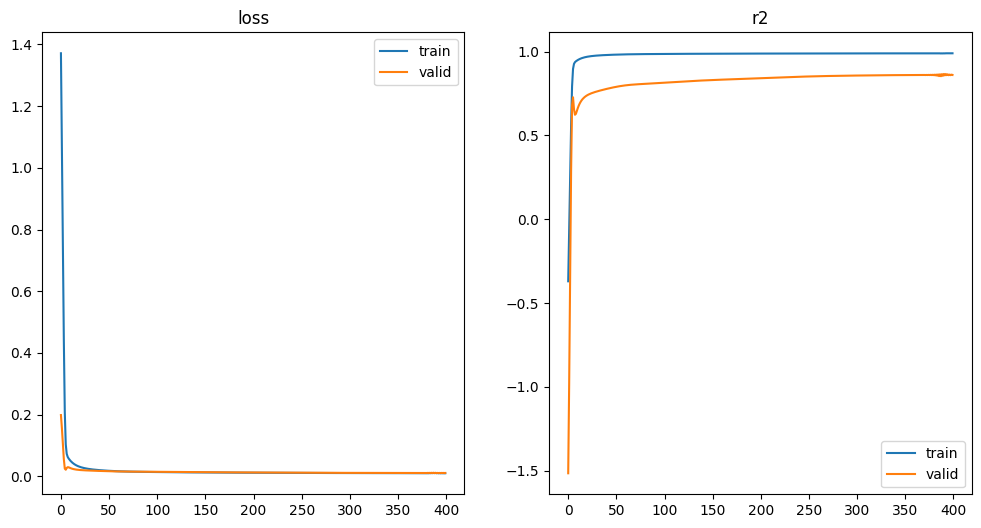

In [77]:
f,a = plt.subplots(1,2,figsize = (12,6))
a[0].plot(train_hist,label = 'train')
a[0].plot(valid_hist,label = 'valid')
a[0].legend()
a[0].set_title('loss')

a[1].plot(train_r2_hist,label = 'train')
a[1].plot(valid_r2_hist,label = 'valid')
a[1].legend()
a[1].set_title('r2')

In [81]:
val_loop(model,loss_fn,test_loader)

valid loss  0.02 r2  0.98


(0.023153935159955705, 0.9825707479086944)

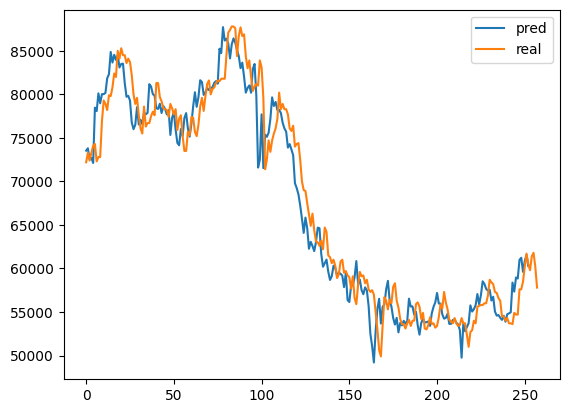

In [79]:
# 실제 예측 시각화
pred = model(test_dataset.data)
test_pred = scaler_y.inverse_transform(pred.detach().numpy())
real = df[int(0.8*len(df)):]['Close']
real.index = range(0,258)
plt.plot(test_pred,label = 'pred')
plt.plot(real,label = 'real')
plt.legend()

### 배운점 : input feature와 target은 스케일이 비슷해야 안정적으로, 빠르게 학습 가능하다. target에 스케일링 미 적용시 에폭을 매우 많이 시도해야 한다는 것을 알게 됨, linear layer의 파라미터가 비슷해 질 때 까지 값이 업데이트 되어야 하기 때문

### 사실 현재 예측은 오버피팅 상태이다. 모델은 loss를 최소화 하기 위해, 다음날 주가가 증가하지 않는다는 예측을 하는 상태

### 해결 방안은 -> 피처를 더 넣기

[참고 블로그](https://codingapple.com/unit/deep-learning-stock-price-ai/)